In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Video Analysis") \
    .getOrCreate()


# Định nghĩa schema mới
video_schema = StructType([
    StructField("Video ID", StringType(), True),
    StructField("Title", StringType(), True),
    StructField("Category_ID", IntegerType(), True),
    StructField("Published At", TimestampType(), True),
    StructField("Channel Title", StringType(), True),
    StructField("View Count", IntegerType(), True),
    StructField("Like Count", IntegerType(), True),
    StructField("Comment Count", IntegerType(), True),
])

# Đọc file CSV với schema mới
file_path = "video.csv"
df = spark.read.option("header", "true").schema(video_schema).csv(file_path)

# Kiểm tra schema và hiển thị dữ liệu
df.printSchema()
df.show()
# Kiểm tra số hàng và cột
print(f"Số hàng: {df.count()}, Số cột: {len(df.columns)}")

root
 |-- Video ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Category_ID: integer (nullable = true)
 |-- Published At: timestamp (nullable = true)
 |-- Channel Title: string (nullable = true)
 |-- View Count: integer (nullable = true)
 |-- Like Count: integer (nullable = true)
 |-- Comment Count: integer (nullable = true)

+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|   Video ID|               Title|Category_ID|       Published At|   Channel Title|View Count|Like Count|Comment Count|
+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|N-gpD9QqTK0|Nấu đám tiệc kiểu...|         19|2024-12-01 17:44:37|Khoai Lang Thang|   1520244|     37496|         1969|
|M_WD9Dxayk8|Đến nhà người lạ ...|         19|2024-11-17 18:57:32|Khoai Lang Thang|   1602732|     28690|         1378|
|5AJd2FJUVkc|Ăn 10 món lạ ở kh...|         19|202

In [2]:
# Kiểm tra số lượng giá trị null mỗi cột


# Loại bỏ giá trị null (nếu cần)
df_clean = df.dropna()


In [3]:
df_clean.printSchema()

root
 |-- Video ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Category_ID: integer (nullable = true)
 |-- Published At: timestamp (nullable = true)
 |-- Channel Title: string (nullable = true)
 |-- View Count: integer (nullable = true)
 |-- Like Count: integer (nullable = true)
 |-- Comment Count: integer (nullable = true)



In [4]:
df_clean.show()
print(f"Số hàng: {df_clean.count()}, Số cột: {len(df_clean.columns)}")

+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|   Video ID|               Title|Category_ID|       Published At|   Channel Title|View Count|Like Count|Comment Count|
+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|N-gpD9QqTK0|Nấu đám tiệc kiểu...|         19|2024-12-01 17:44:37|Khoai Lang Thang|   1520244|     37496|         1969|
|M_WD9Dxayk8|Đến nhà người lạ ...|         19|2024-11-17 18:57:32|Khoai Lang Thang|   1602732|     28690|         1378|
|5AJd2FJUVkc|Ăn 10 món lạ ở kh...|         19|2024-11-05 20:27:52|Khoai Lang Thang|   2130532|     29506|         1236|
|92-IbWKp_3k|Gặp nạn ở CHỢ TRỜ...|         19|2024-10-27 18:52:00|Khoai Lang Thang|   1779109|     24698|         1794|
|MLBhMV8k6e0|Du lịch ẩm thực C...|         19|2024-10-16 21:05:48|Khoai Lang Thang|   2031031|     28867|         1248|
|cJD4fc5l3fM|Châu Phi p8: HÀNG...|      

In [5]:
# Mô tả thống kê
df_clean.describe().show()

# Thống kê lượt xem (views)


+-------+-----------+--------------------+------------------+----------------+------------------+------------------+------------------+
|summary|   Video ID|               Title|       Category_ID|   Channel Title|        View Count|        Like Count|     Comment Count|
+-------+-----------+--------------------+------------------+----------------+------------------+------------------+------------------+
|  count|        284|                 284|               284|             284|               284|               284|               284|
|   mean|       NULL|                NULL|19.433098591549296|            NULL|2267935.3767605633|26922.975352112677|1581.9788732394366|
| stddev|       NULL|                NULL|2.2633419685435197|            NULL|1518302.5854609765| 16322.17740844484|1292.2597402616855|
|    min|-VfFP4zpkZo|"""Tết Kate"" ở V...|                10|Khoai Lang Thang|             59105|               960|                66|
|    max|zs9xbXCOT6Y|🇹🇭Đi về phương ...|        

- TỔng lượt xem của mỗi category

In [6]:
from pyspark.sql.functions import col, sum

# Chuyển cột "View Count" sang kiểu Integer
df_clean = df_clean.withColumn("View Count", col("View Count").cast("int"))

# Thực hiện nhóm và tính tổng số video theo category
df_category=df_clean.groupBy("Category_ID") \
                    .agg(sum("View Count").alias("Total Views")) \
                    .orderBy(col("Total Views").desc()) 
df_category.show()


+-----------+-----------+
|Category_ID|Total Views|
+-----------+-----------+
|         19|  590550047|
|         24|   36836146|
|         10|   11178060|
|         22|    5077519|
|         15|     451875|
+-----------+-----------+



- Số lượng video của mỗi category

In [7]:
from pyspark.sql.functions import count

# Nhóm dữ liệu theo Category_ID và sau đó đếm số lần xuất hiện của Video ID
df_category_video=df_clean.groupBy("Category_ID") \
    .agg(count("Video ID").alias("Video Count")) \
    .orderBy(col("Video Count").desc()) 
df_category_video.show()


+-----------+-----------+
|Category_ID|Video Count|
+-----------+-----------+
|         19|        236|
|         24|         35|
|         10|          7|
|         22|          5|
|         15|          1|
+-----------+-----------+



- 10 video có lượt xem cao nhất

In [8]:
Top_10_video_view=df_clean.groupBy("Video ID","Title")\
                        .agg(sum("View Count").alias("Total View"))\
                        .orderBy(col("Total View"),ascending=False)\
                        .limit(10)
Top_10_video_view.show()

+-----------+--------------------+----------+
|   Video ID|               Title|Total View|
+-----------+--------------------+----------+
|v32lFxUUV5o|Đám Cưới Miệt Vườ...|   8107261|
|5QCsAh9Eays|ĂN NGON & RẺ KHÔN...|   7891063|
|3i3cDuGayqg|🇰🇷Chợ Gwangjang...|   7680470|
|O8nVnHlmhCM|CHỢ CHÂU ĐỐC • TH...|   7403760|
|hK-s3LsZcFc|🇹🇭Chợ đêm biên ...|   6804373|
|TyzP2yUATuM|Đám giỗ bên cồn t...|   6516807|
|a-2iTFdtnvk|Cuộc sống bản Phù...|   6045537|
|7txU8f9Dl5c|ĂN BUFFET 5 SAO Ở...|   5891310|
|p_u50y858kY|Nấu ĐÁM GIỖ từ ba...|   5738110|
|zc3A_CxSyc4|Nấu đám miệt vườn...|   5575163|
+-----------+--------------------+----------+



In [9]:
Top_10_video_like=df_clean.groupBy("Video ID","Title")\
                        .agg(sum("Like Count").alias("Total like"))\
                        .orderBy(col("Total like"),ascending=False)\
                        .limit(10)
Top_10_video_like.show()

+-----------+--------------------+----------+
|   Video ID|               Title|Total like|
+-----------+--------------------+----------+
|TrbtMqHSmcc|800 NGÀY ĐI KHẮP ...|    137707|
|wjDs5zwRlMA|(Official Music V...|     93884|
|36ms9Si7f8I|XIN LỖI - KHOAI |...|     92510|
|T02aU8qpshQ|10 năm & BÍ MẬT C...|     88221|
|v32lFxUUV5o|Đám Cưới Miệt Vườ...|     78135|
|a0RLS40Qh-A|Việt Nam chuyện c...|     63578|
|MZxiqm-JkfY|Bánh đúc thủ công...|     62743|
|a-2iTFdtnvk|Cuộc sống bản Phù...|     61219|
|3i3cDuGayqg|🇰🇷Chợ Gwangjang...|     57065|
|TyzP2yUATuM|Đám giỗ bên cồn t...|     55756|
+-----------+--------------------+----------+



In [10]:
Top_10_video_like=df_clean.groupBy("Video ID","Title")\
                        .agg(sum("Comment Count").alias("Total comment"))\
                        .orderBy(col("Total comment"),ascending=False)\
                        .limit(10)
Top_10_video_like.show()

+-----------+--------------------+-------------+
|   Video ID|               Title|Total comment|
+-----------+--------------------+-------------+
|TrbtMqHSmcc|800 NGÀY ĐI KHẮP ...|        13160|
|36ms9Si7f8I|XIN LỖI - KHOAI |...|         9190|
|v32lFxUUV5o|Đám Cưới Miệt Vườ...|         6202|
|TyzP2yUATuM|Đám giỗ bên cồn t...|         5589|
|4V4KjfmH5vw|ĐẶC SẢN QUÝ HIẾM ...|         5537|
|wjDs5zwRlMA|(Official Music V...|         4823|
|T02aU8qpshQ|10 năm & BÍ MẬT C...|         4708|
|a0RLS40Qh-A|Việt Nam chuyện c...|         4449|
|5QCsAh9Eays|ĂN NGON & RẺ KHÔN...|         4431|
|a-2iTFdtnvk|Cuộc sống bản Phù...|         4366|
+-----------+--------------------+-------------+



- Số lượng video mỗi năm

In [11]:
from pyspark.sql.functions import year, month

# Thêm cột năm, tháng nếu có cột ngày phát hành
df_clean = df_clean.withColumn("year", year(col("Published At"))) \
                   .withColumn("month", month(col("Published At")))

# Số lượng video theo năm
df_count_video_year=df_clean.groupBy("year").count().orderBy("year")
df_count_video_year.show()


+----+-----+
|year|count|
+----+-----+
|2017|   48|
|2018|   58|
|2019|   50|
|2020|   28|
|2021|   16|
|2022|   26|
|2023|   35|
|2024|   23|
+----+-----+



In [12]:
df_clean.show()

+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+----+-----+
|   Video ID|               Title|Category_ID|       Published At|   Channel Title|View Count|Like Count|Comment Count|year|month|
+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+----+-----+
|N-gpD9QqTK0|Nấu đám tiệc kiểu...|         19|2024-12-01 17:44:37|Khoai Lang Thang|   1520244|     37496|         1969|2024|   12|
|M_WD9Dxayk8|Đến nhà người lạ ...|         19|2024-11-17 18:57:32|Khoai Lang Thang|   1602732|     28690|         1378|2024|   11|
|5AJd2FJUVkc|Ăn 10 món lạ ở kh...|         19|2024-11-05 20:27:52|Khoai Lang Thang|   2130532|     29506|         1236|2024|   11|
|92-IbWKp_3k|Gặp nạn ở CHỢ TRỜ...|         19|2024-10-27 18:52:00|Khoai Lang Thang|   1779109|     24698|         1794|2024|   10|
|MLBhMV8k6e0|Du lịch ẩm thực C...|         19|2024-10-16 21:05:48|Khoai Lang Thang|

- Tạo partition theo năm, tháng


In [13]:
output="D:/Big Data Analysis/cuoiki/get_api/partition"
df_clean.write.partitionBy("year", "month") \
    .mode("overwrite") \
    .parquet(output)

In [14]:
df_partitioned = spark.read.parquet("partition")

# Kiểm tra schema (các cột year, month sẽ được tự động thêm)
df_partitioned.printSchema()

# Truy vấn dữ liệu
df_partitioned.filter("year = 2024 AND month = 3").show()


root
 |-- Video ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Category_ID: integer (nullable = true)
 |-- Published At: timestamp (nullable = true)
 |-- Channel Title: string (nullable = true)
 |-- View Count: integer (nullable = true)
 |-- Like Count: integer (nullable = true)
 |-- Comment Count: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+----+-----+
|   Video ID|               Title|Category_ID|       Published At|   Channel Title|View Count|Like Count|Comment Count|year|month|
+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+----+-----+
|FDMDKktG75I|Lặn biển tìm hải ...|         19|2024-03-31 22:27:10|Khoai Lang Thang|   3354618|     32408|         1167|2024|    3|
|NTEgu8uWS1I|Du lịch Mỹ tự túc...|         19|2024

- Tỉ lệ tương tác theo video

In [ ]:
df_tuong_tac = df_clean.selectExpr("`Video ID`","(`Like Count` + `Comment Count`) / `View Count` as Ti_le_tuong_tac")\
                        .orderBy("Ti_le_tuong_tac", ascending=False)

df_tuong_tac.show()


+-----------+--------------------+
|   Video ID|     Ti_le_tuong_tac|
+-----------+--------------------+
|XdbjuI86zhM| 0.07914200821377348|
|a0RLS40Qh-A| 0.07401455549595638|
|36ms9Si7f8I| 0.05627321892772128|
|q5EPifZQK8I| 0.05039767513000918|
|xXTcKSxGClQ| 0.04872383460159695|
|TrbtMqHSmcc| 0.04163283890996895|
|wjDs5zwRlMA| 0.03859600280123764|
|kL-XgVsV8EI| 0.03678875611256841|
|zMn9mithu84| 0.03601119164946227|
|CnlXly4_b9Y|0.032958957796567115|
|quZy6AhGmEc|0.032448847884032295|
|OWlik0yAwoc| 0.03187260153091588|
|JYULx2AItoI| 0.03140695915279879|
|SYcnSZfXwWw|0.030660321797922212|
|RvMcyBS8SgU|0.030424938025804687|
|5ta7YnZ1K_o|0.030185685932506125|
|V_2_CPiTDR4|  0.0295407755862526|
|T02aU8qpshQ| 0.02926931746921145|
|SLpU2LGv54g|0.029211199642519933|
|wX-TrSDnAys| 0.02893649585103135|
+-----------+--------------------+
only showing top 20 rows



- Tỉ lệ tương tác theo category

In [21]:
# Dùng groupBy với selectExpr gián tiếp
df_aggregated = df_clean.groupBy("Category_ID").agg(
    expr("SUM(`Like Count`) as Total_Likes"),
    expr("SUM(`Comment Count`) as Total_Comments"),
    expr("SUM(`View Count`) as Total_Views")
)

# Sau đó dùng selectExpr để tính Ti_le_tuong_tac
df_tuong_tac_category = df_aggregated.selectExpr(
    "Category_ID",
    "(Total_Likes + Total_Comments) / Total_Views as Ti_le_tuong_tac"
).orderBy("Ti_le_tuong_tac", ascending=False)

df_tuong_tac_category.show()


+-----------+--------------------+
|Category_ID|     Ti_le_tuong_tac|
+-----------+--------------------+
|         22| 0.03472955984999761|
|         10| 0.03354419282057888|
|         15|  0.0142716459197787|
|         19|0.012093535571253625|
|         24|0.010745450949184531|
+-----------+--------------------+



- View trung bình cho mỗi video

In [37]:
from pyspark.sql.functions import expr

View_tb = df_clean.agg( 
                            (expr("COUNT(`Video ID`)")).alias("Total_Video"),
                            (expr("SUM(`View Count`)")).alias("Total_View"),
                            (expr("SUM(`View Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Views_Per_Video"),
                            (expr("SUM(`Like Count`)")).alias("Total_Like"),
                            (expr("SUM(`Like Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Likes_Per_Video"),
                            (expr("SUM(`Comment Count`)")).alias("Total_Comment"),
                            (expr("SUM(`Comment Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Comment_Per_Video")
)

View_tb.show()


+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|Total_Video|Total_View|Average_Views_Per_Video|Total_Like|Average_Likes_Per_Video|Total_Comment|Average_Comment_Per_Video|
+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|        284| 644093647|     2267935.3767605633|   7646125|     26922.975352112677|       449282|       1581.9788732394366|
+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+



In [35]:
from pyspark.sql.functions import expr

View_tb_year = df_clean.groupby("Year")\
                        .agg( 
                            (expr("COUNT(`Video ID`)")).alias("Total_Video"),
                            (expr("SUM(`View Count`)")).alias("Total_View"),
                            (expr("SUM(`View Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Views_Per_Video"),
                            (expr("SUM(`Like Count`)")).alias("Total_Like"),
                            (expr("SUM(`Like Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Likes_Per_Video"),
                            (expr("SUM(`Comment Count`)")).alias("Total_Comment"),
                            (expr("SUM(`Comment Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Comment_Per_Video"))\
                        .orderBy("year")

View_tb_year.show()


+----+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|Year|Total_Video|Total_View|Average_Views_Per_Video|Total_Like|Average_Likes_Per_Video|Total_Comment|Average_Comment_Per_Video|
+----+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|2017|         48|  53855107|     1121981.3958333333|    566504|     11802.166666666666|        45151|        940.6458333333334|
|2018|         58| 137904607|     2377665.6379310344|   1335530|     23026.379310344826|        94382|       1627.2758620689656|
|2019|         50| 107469646|             2149392.92|   1610016|               32200.32|       112736|                  2254.72|
|2020|         28|  68516080|     2447002.8571428573|    952112|                34004.0|        59969|                  2141.75|
|2021|         16|  38998764|             2437422.75|    513688|                32105.5|        3

In [40]:
from pyspark.sql.functions import expr

View_Like_Comment_tb_year_month = df_clean.groupby("Year","month")\
                        .agg( 
                            (expr("COUNT(`Video ID`)")).alias("Total_Video"),
                            (expr("SUM(`View Count`)")).alias("Total_View"),
                            (expr("SUM(`View Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Views_Per_Video"),
                            (expr("SUM(`Like Count`)")).alias("Total_Like"),
                            (expr("SUM(`Like Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Likes_Per_Video"),
                            (expr("SUM(`Comment Count`)")).alias("Total_Comment"),
                            (expr("SUM(`Comment Count`)") / expr("COUNT(`Video ID`)")).alias("Average_Comment_Per_Video"))\
                        .orderBy("year","month")

View_Like_Comment_tb_year_month.show()


+----+-----+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|Year|month|Total_Video|Total_View|Average_Views_Per_Video|Total_Like|Average_Likes_Per_Video|Total_Comment|Average_Comment_Per_Video|
+----+-----+-----------+----------+-----------------------+----------+-----------------------+-------------+-------------------------+
|2017|    2|          2|   1224273|               612136.5|     13479|                 6739.5|         1217|                    608.5|
|2017|    3|          5|   4008293|               801658.6|     40684|                 8136.8|         2694|                    538.8|
|2017|    4|          5|   2757327|               551465.4|     29915|                 5983.0|         2252|                    450.4|
|2017|    5|          3|   1821947|      607315.6666666666|     18036|                 6012.0|         1047|                    349.0|
|2017|    6|          8|   5491449|             686431.

In [44]:
# Chuyển đổi DataFrame Spark thành Pandas DataFrame
pd_data = View_Like_Comment_tb_year_month.toPandas()

# Tạo cột thời gian (Year-Month) để sử dụng làm trục x
pd_data["Year_Month"] = pd_data["Year"].astype(str) + "-" + pd_data["month"].astype(str)

# Sắp xếp dữ liệu theo thời gian
pd_data = pd_data.sort_values(by=["Year", "month"])


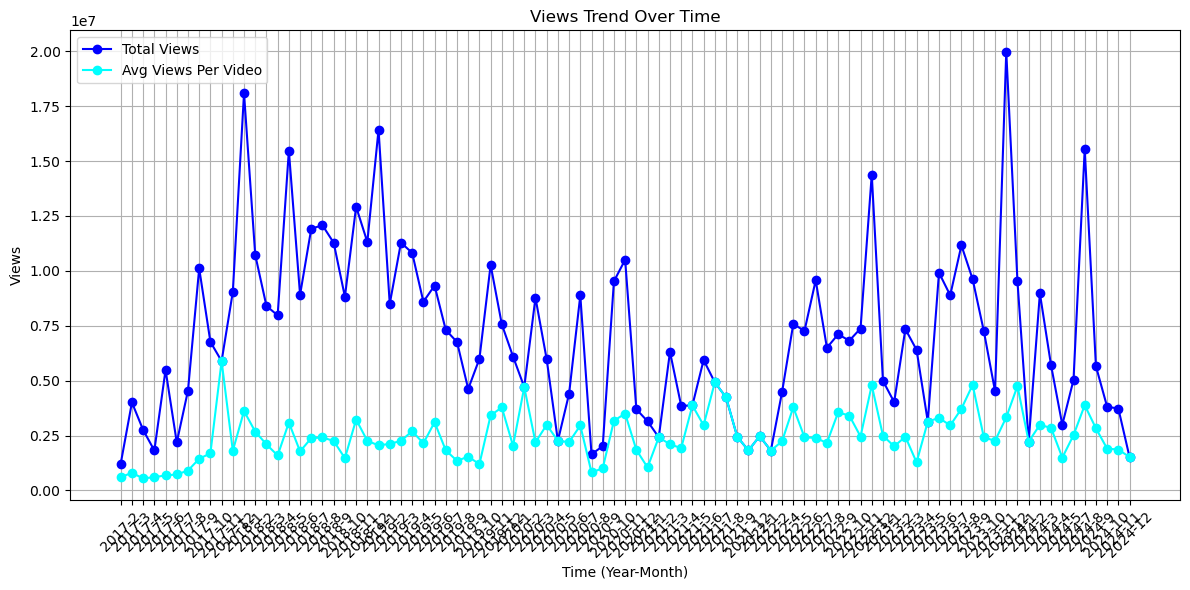

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pd_data["Year_Month"], pd_data["Total_View"], label="Total Views", color="blue", marker="o")
plt.plot(pd_data["Year_Month"], pd_data["Average_Views_Per_Video"], label="Avg Views Per Video", color="cyan", marker="o")

plt.title("Views Trend Over Time")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Views")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


- Like

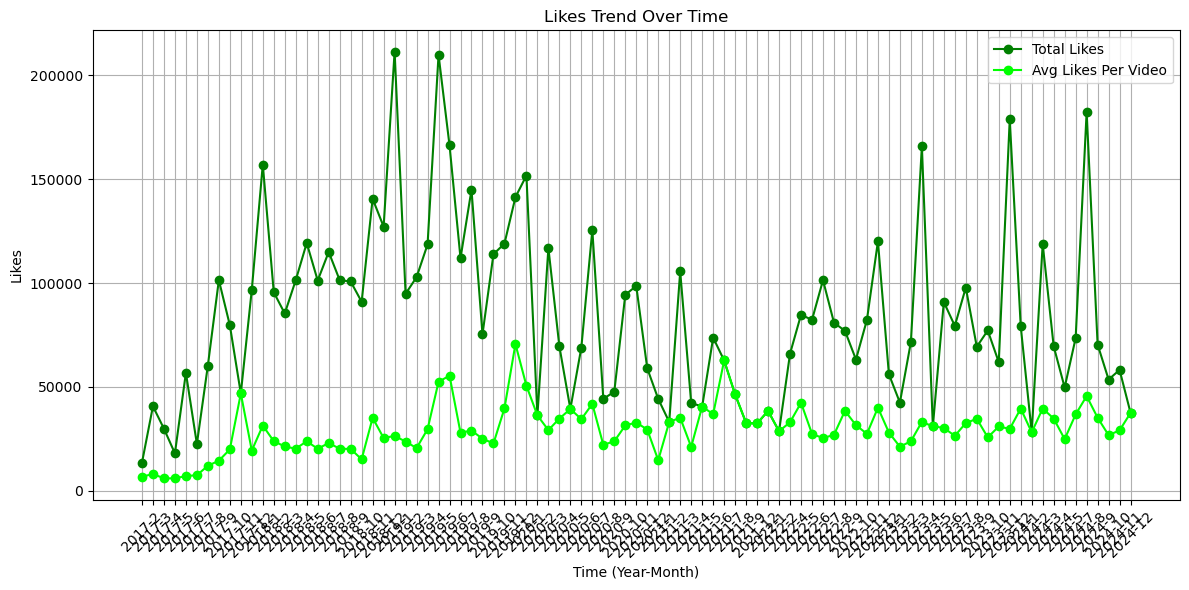

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(pd_data["Year_Month"], pd_data["Total_Like"], label="Total Likes", color="green", marker="o")
plt.plot(pd_data["Year_Month"], pd_data["Average_Likes_Per_Video"], label="Avg Likes Per Video", color="lime", marker="o")

plt.title("Likes Trend Over Time")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Likes")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


- Comment

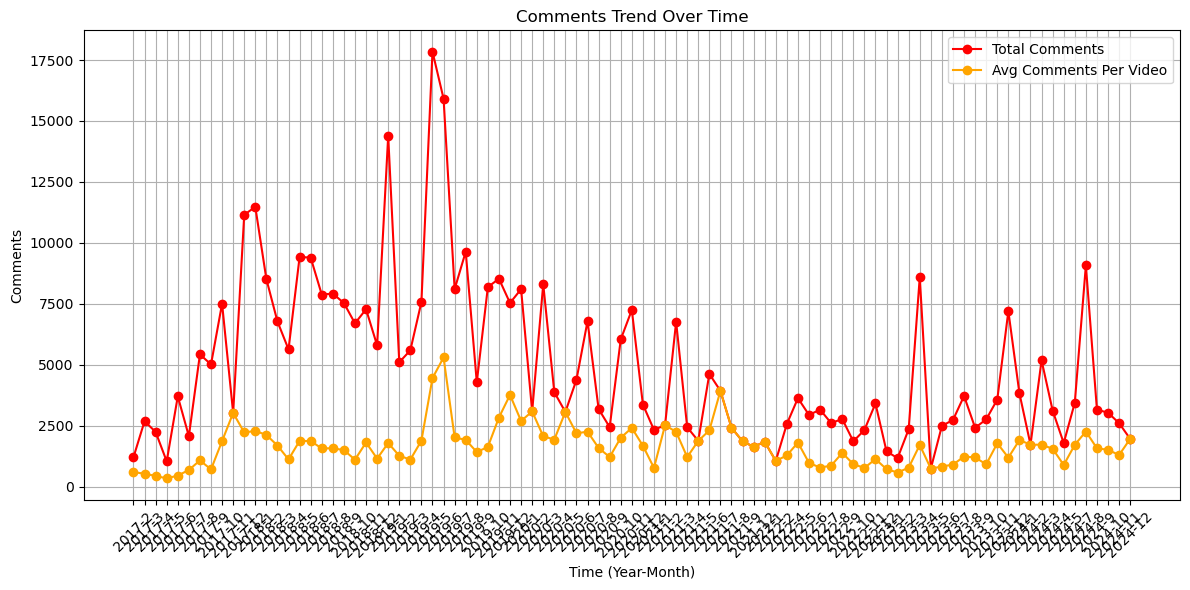

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(pd_data["Year_Month"], pd_data["Total_Comment"], label="Total Comments", color="red", marker="o")
plt.plot(pd_data["Year_Month"], pd_data["Average_Comment_Per_Video"], label="Avg Comments Per Video", color="orange", marker="o")

plt.title("Comments Trend Over Time")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Comments")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
